In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd '/content/drive/MyDrive/Image_Processing_Project'

/content/drive/.shortcut-targets-by-id/1Z_svIpb1LE3Sg4FE4K6Qc8_lm08Bp6Qg/Image_Processing_Project


In [3]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 6.4 MB/s eta 0:00:00


In [4]:
# DL imports
import torch
from torch import nn
from torchvision.transforms import ToTensor
from torchvision.transforms import transforms
from torch.optim import Adam
import torchvision.transforms.functional as TF

from torch.utils.data import  Dataset
from torch.utils.data import  DataLoader

import torchmetrics

# Other imports
import os
from tqdm import tqdm
import glob

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IMG_SIZE = (216, 384)


In [6]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) + x

class ConvMixerBlock(nn.Module):
    def __init__(self, dim=1024, depth=7, k=7):
        super(ConvMixerBlock, self).__init__()
        self.block = nn.Sequential(
            *[nn.Sequential(
                Residual(nn.Sequential(
                    # deep wise
                    nn.Conv2d(dim, dim, kernel_size=(k, k), groups=dim, padding=(k // 2, k // 2)),
                    nn.GELU(),
                    nn.BatchNorm2d(dim)
                )),
                nn.Conv2d(dim, dim, kernel_size=(1, 1)),
                nn.GELU(),
                nn.BatchNorm2d(dim)
            ) for i in range(depth)]
        )

    def forward(self, x):
        x = self.block(x)
        return x

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):

        super(DoubleConv, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True), )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],):

        super(UNET, self).__init__()

        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.convMixer = ConvMixerBlock(dim=1024, depth=7, k=7)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )

            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        x = self.convMixer(x)

        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)


tree_model = UNET().to(DEVICE)
building_model = UNET().to(DEVICE)


In [7]:
def overlap(image,label,intensity=128):

    label = label.convert("RGBA")

    r, g, b, a = label.split()

    overlay_intensity = intensity
    a = a.point(lambda i: overlay_intensity)

    label = Image.merge("RGBA", (r, g, b, a))

    result = Image.alpha_composite(image.convert("RGBA"), label)

    return result

def visualize(image, mask, label=None, truth=None,  augment=False, overlay=False):
    if truth is None:
        plt.figure(figsize=(14, 20))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        if augment == False:
            plt.title(f"{'Original Image'}")
        else:
            plt.title(f"{'Augmented Image'}")

        plt.subplot(1, 2, 2)
        plt.imshow(mask)
        if label is not None:
            plt.title(f"{label.capitalize()}")

    elif overlay:
        plt.figure(figsize=(26, 36))
        plt.subplot(1,2, 1)
        plt.imshow(image)
        plt.title(f"{'Original Image'}")

        plt.subplot(1,2, 2)
        plt.imshow(mask)
        plt.title(f"{'Prediction'}")

        plt.show()

        plt.figure(figsize=(26, 36))

        plt.subplot(1,2, 1)
        plt.imshow(truth)
        plt.title(f"{'Ground Truth'}")

        plt.subplot(1,2, 2)
        plt.imshow(overlap(image,mask))
        plt.title(f"{'Overlay'}")

    else:
        plt.figure(figsize=(26, 36))
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title(f"{'Original Image'}")

        plt.subplot(1, 3, 2)
        plt.imshow(mask)
        plt.title(f"{'Prediction'}")

        plt.subplot(1, 3, 3)
        plt.imshow(truth)
        plt.title(f"{'Ground Truth'}")



In [8]:
#image transform
image_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
])

#mask transform
label_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.Grayscale(),
    transforms.ToTensor(),
])

In [11]:
tree_model_loc = './checkpoint_tree/model_10.pth.tar'
building_model_loc = './checkpoint_building/model_10.pth.tar'

tree_checkpoint = torch.load(tree_model_loc)
tree_model.load_state_dict(tree_checkpoint['state_dict'])
tree_model.eval()

building_checkpoint = torch.load(building_model_loc)
building_model.load_state_dict(building_checkpoint['state_dict'])
building_model.eval()

print("completed")


completed


In [25]:
# convert 3 channel color code to scalar value

class ColourTransformer:

    def __init__(self):

        self.colour_table = self.get_colour_table()
        self.id_table = self.convert2_id()

    def get_colour_table(self):

        colour_table = {}

        colour_table['Building'] = [128, 0, 0]
        colour_table['Road'] = [128, 64, 128]
        colour_table['Static_Car'] = [192, 0, 192]
        colour_table['Tree'] = [0, 128, 0]
        colour_table['Vegetation'] = [128, 128, 0]
        colour_table['Human'] = [64, 64, 0]
        colour_table['Moving_Car'] = [64, 0, 128]
        colour_table['Clutter'] = [0, 0, 0]

        return colour_table

    def convert2_id(self):

        id_table = {}

        for item in self.colour_table.keys():
            r,g,b = self.colour_table[item]
            id_table[item] = r + g*255 + b*255*255

        return id_table


    def label_transform(self, label, dtype=np.int8, do_reshape=False):

        if do_reshape:
          label = np.array(Image.open(label).resize((IMG_SIZE[1],IMG_SIZE[0])))
        else:
          label = np.array(Image.open(label))

        height,width = label.shape[:2]

        if do_reshape:
          newLabel = np.zeros((height, width), dtype=np.int64)
        else:
          newLabel = np.zeros((height, width), dtype=dtype)

        id_label = label.astype(np.int64)
        id_label = id_label[:,:,0]+id_label[:,:,1]*255+id_label[:,:,2]*255*255

        if do_reshape:

          mask = (id_label == self.id_table['Tree'])
          newLabel[mask] = 127

          mask = (id_label == self.id_table['Building'])
          newLabel[mask] = 255

        else:
          mask = (id_label == self.id_table['Tree'])
          newLabel[mask] = 1

          mask = (id_label == self.id_table['Building'])
          newLabel[mask] = 2

        return newLabel

    def enhance(self,image):
      pass


colour_transformer = ColourTransformer()



In [13]:

def predict(tree_model,building_model,image):

    image = image_transform(Image.open(image))
    image = image.unsqueeze(0).to(DEVICE)

    tree_pred = None
    building_pred = None

    with torch.no_grad():
        tree_pred = torch.sigmoid(tree_model(image))
        tree_pred = (tree_pred > 0.5).float()

        building_pred = torch.sigmoid(building_model(image))
        building_pred = (building_pred > 0.5).float()


    tree_pred_pil = transforms.ToPILImage()(tree_pred.squeeze(0))
    building_pred_pil = transforms.ToPILImage()(building_pred.squeeze(0))

    tree_pred_np = np.array(tree_pred_pil)
    building_pred_np = np.array(building_pred_pil)

    new_label = np.zeros_like(tree_pred_np, dtype=np.uint8)

    new_label[tree_pred_np != 0] = 127

    new_label[building_pred_np != 0] = 255


    return new_label

In [14]:
test_img_path = './dataset/valid/seq16/Images/000000.png'
test_label_path = test_img_path.replace('Images','Labels')
test_label = colour_transformer.label_transform(test_img_path.replace('Images','Labels'))

ensemble_label_np = predict(tree_model,building_model,test_img_path)
ensemble_label = Image.fromarray(ensemble_label_np)

colour_transformer.enhance(ensemble_label)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [15]:
def compare_visual(image,ori_label,pred_label):
        plt.figure(figsize=(26, 36))
        plt.subplot(1,2, 1)
        plt.imshow(image)
        plt.title(f"{'Original Image'}")

        plt.subplot(1,2, 2)
        plt.imshow(pred_label)
        plt.title(f"{'Prediction'}")

        plt.show()

        plt.figure(figsize=(26, 36))

        plt.subplot(1,2, 1)
        plt.imshow(ori_label)
        plt.title(f"{'Ground Truth'}")

        image = image.resize(pred_label.size)

        result_image = Image.alpha_composite(Image.new("RGBA", pred_label.size, (0, 0, 0, 0)), Image.alpha_composite(pred_label.convert("RGBA"), image.convert("RGBA")))

        plt.subplot(1,2, 2)
        plt.imshow(overlap(result_image,pred_label))
        plt.title(f"{'Overlay'}")

<class 'numpy.ndarray'> (216, 384)
<class 'numpy.ndarray'> (216, 384)


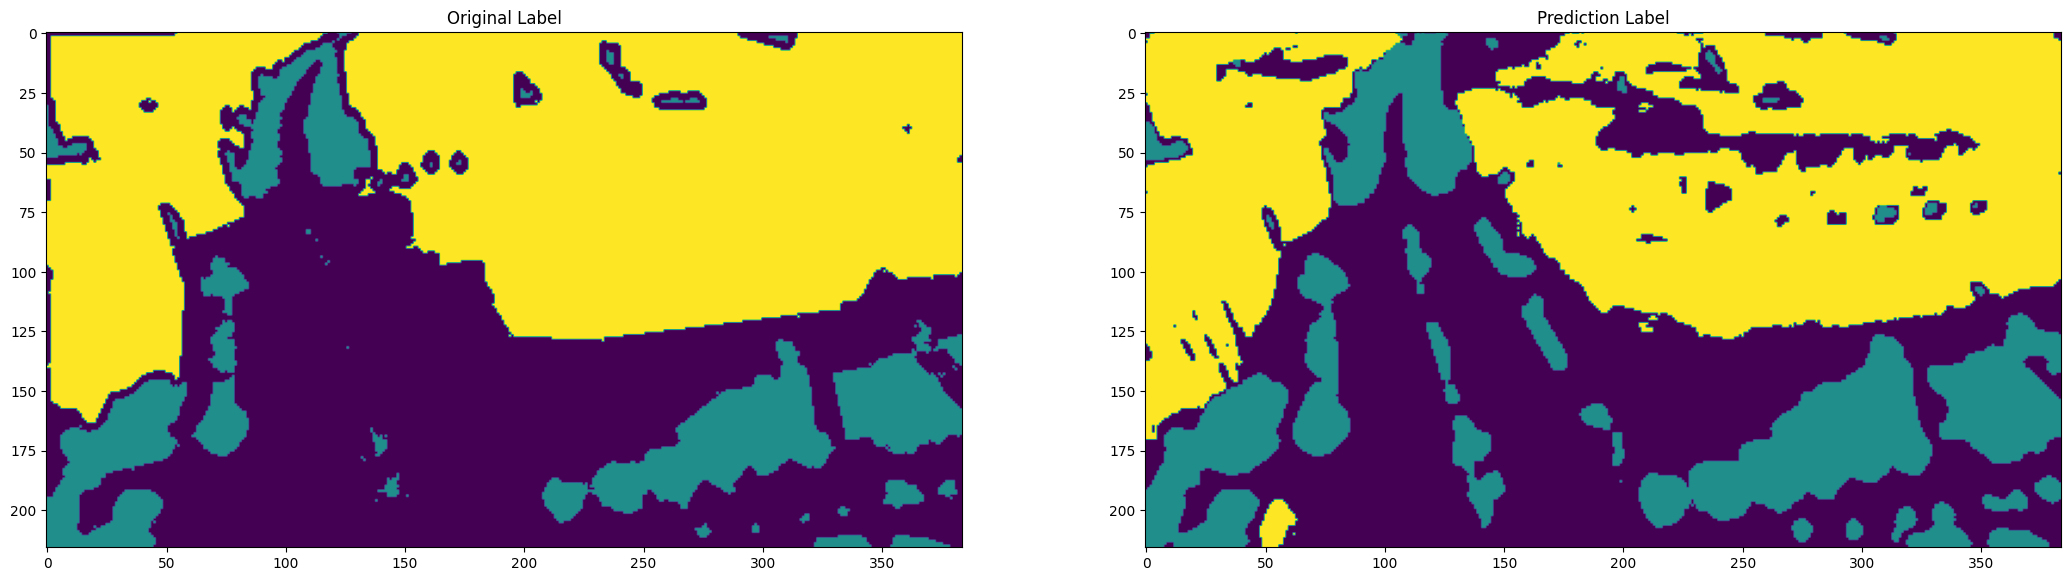

Accuracy: 84.9247694015503%


In [24]:


def accuracy(test_label_path,ensemble_label):

  test_label = colour_transformer.label_transform(test_label_path,do_reshape=True)
  # return
  dice_score = torchmetrics.Dice()
  dice_score.to(DEVICE)

  print(type(test_label),test_label.shape)
  print(type(ensemble_label), ensemble_label.shape)

  plt.figure(figsize=(26, 36))
  plt.subplot(1,2, 1)
  plt.imshow(test_label)
  plt.title(f"{'Original Label'}")

  plt.subplot(1,2, 2)
  plt.imshow(ensemble_label)
  plt.title(f"{'Prediction Label'}")

  plt.show()

  ensemble_label = torch.from_numpy(ensemble_label).to(DEVICE)
  test_label = torch.from_numpy(test_label).to(DEVICE)
  dice = dice_score(ensemble_label, test_label)

  print(f"Accuracy: {dice.item()*100}%")

accuracy(test_label_path,ensemble_label_np)

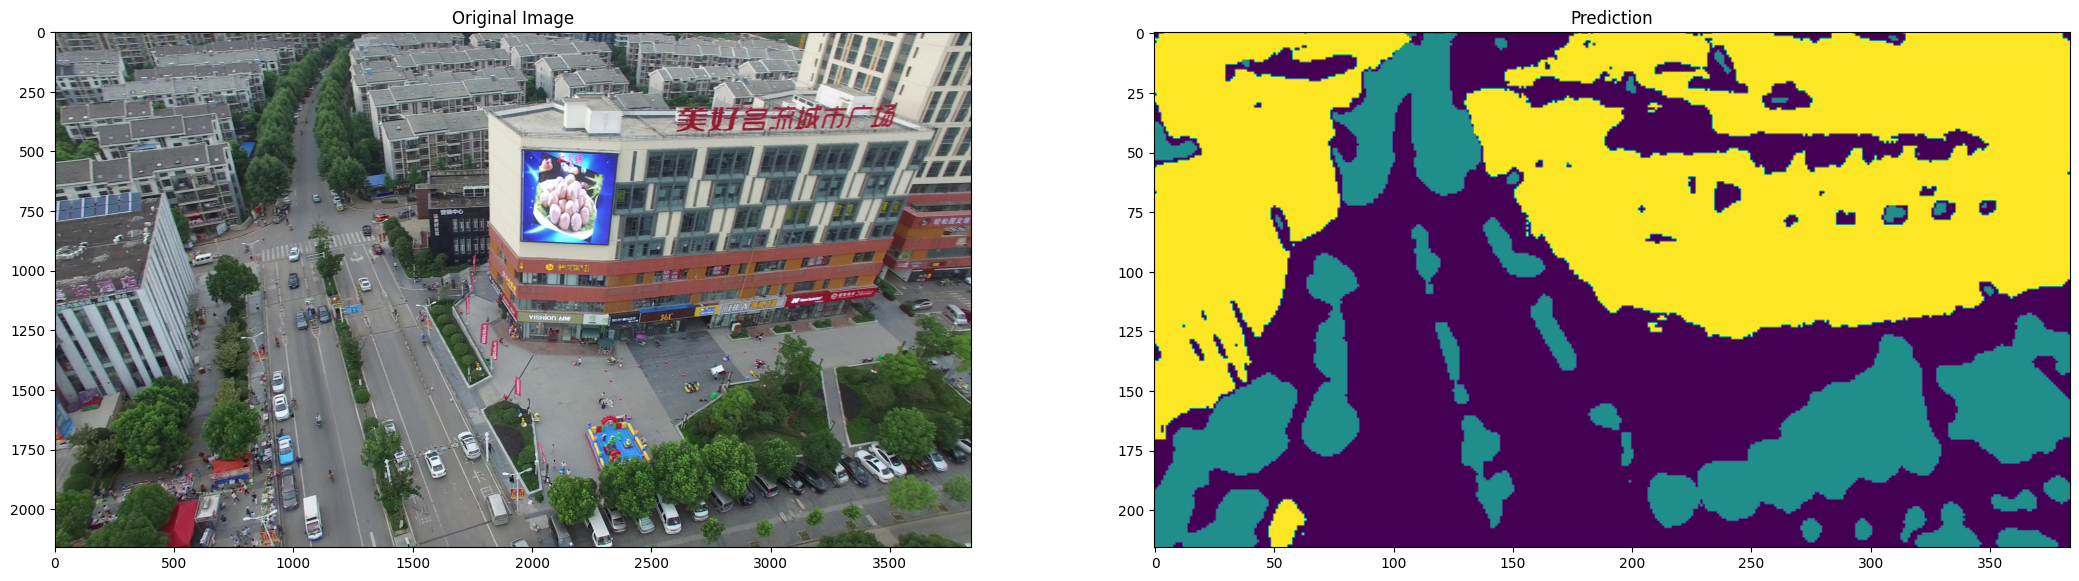

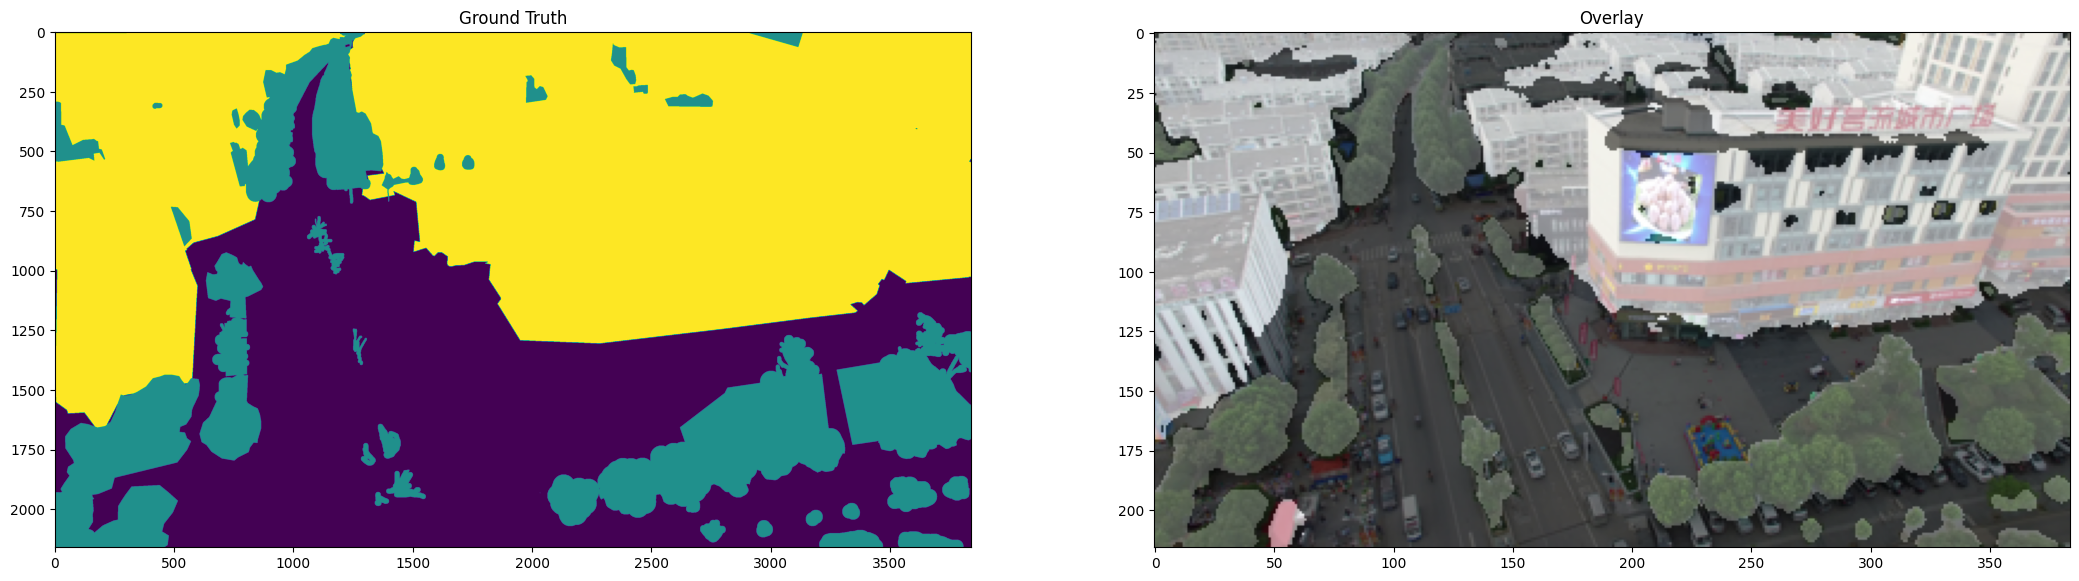

In [26]:

compare_visual(Image.open(test_img_path),test_label,ensemble_label)
